# Adversarial Attacks on MNIST

## 1. Import libraries

In [1]:
### TESTING ON MNIST ###

from py import nets
import torch
import time
from py.utils import get_default_device, imshow
from py.train import train_mnist, test, test_on_attack
from torchattacks import *
from py.attacks import get_attacks
from torch import optim
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from algo.variable_optim import VSGD 
%matplotlib inline

## 2. Load the data

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
            ])

n_epochs = 5
batch_size = 128
learning_rate = 0.01
momentum=0.9

train_set = datasets.MNIST('./datasets', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

test_set = datasets.MNIST('./datasets', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=4)

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

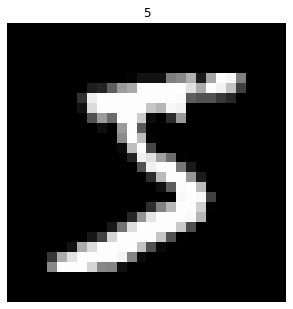

cuda


In [3]:
images, labels = train_set[0]
imshow(torchvision.utils.make_grid(images, normalize=True), labels)
device = get_default_device()
print(device)

## 3. Train base model

In [ ]:
device = get_default_device()
base_model = nets.Conv1()
base_model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(base_model.parameters(), lr=learning_rate, momentum=momentum)

train_losses, train_counter = train_mnist(base_model, optimizer, criterion, 
                                          train_loader, device, batch_size=batch_size, n_epochs=n_epochs,
                                          disp=False)

acc = test(base_model, test_loader, device, classes)
print(f"Standard accuracy: {acc}")

## 4. Run adversarial attacks on base model

### 4.1 Viewing adversarial examples on a single image

Adversarial Image & Predicted Label
------------------------------------------------------------------------------------------
FGSM(model_name=Conv1, device=cuda:0, eps=0.3, attack_mode=default, return_type=float)


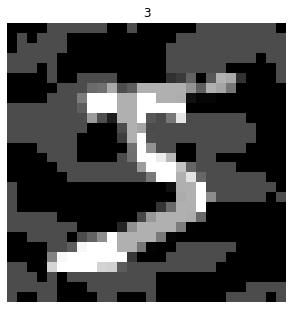

------------------------------------------------------------------------------------------
PGD(model_name=Conv1, device=cuda:0, eps=0.3, alpha=0.1, steps=7, random_start=True, attack_mode=default, return_type=float)


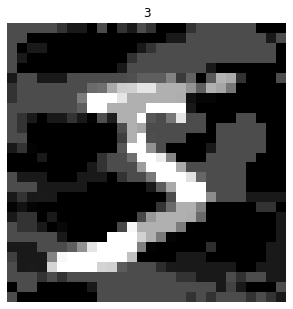

------------------------------------------------------------------------------------------
CW(model_name=Conv1, device=cuda:0, c=5, kappa=0, steps=1000, lr=0.001, attack_mode=default, return_type=float)


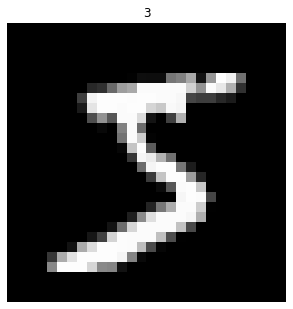

In [5]:
atks = get_attacks(base_model)

print("Adversarial Image & Predicted Label")

data_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False)

for images, labels in data_loader:
    for atk in atks :  
        print("-"*90)
        print(atk)

        correct = 0
        total = 0

        adv_images = atk(images, labels).cuda()
        labels = labels.to(device)
        outputs = base_model(adv_images)

        _, pre = torch.max(outputs.data, 1)

        total += 1
        correct += (pre == labels).sum()
        label = pre.cpu().numpy()[0]
        imshow(torchvision.utils.make_grid(adv_images.cpu().data, normalize=True), label)

    break

    print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))

# Produce plot of adversarial images and labels

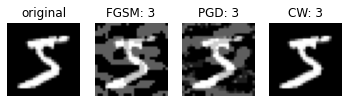

In [6]:
imgs = {}

for images, labels in data_loader:
    imgs["original"] = images[0].cpu()
    for atk in atks:
        adv_images = atk(images, labels).cuda()
        outputs = base_model(adv_images)
        _, pre = torch.max(outputs.data, 1)
        imgs[f"{atk.__class__.__name__}: {pre.cpu()[0]}"] = adv_images[0].cpu()
    break
    
from matplotlib.pyplot import figure, imshow, axis

fig = figure()
for i, (key, value) in enumerate(imgs.items()):
    a=fig.add_subplot(1,len(imgs),i+1)
    a.set_title(key)
    image = value.permute(1, 2, 0)
    imshow(image,cmap='Greys_r')
    axis('off')
fig.savefig('./plots/attacks_applied.png', dpi=300, bbox_inches='tight')   

In [ ]:
#test(base_model, test_loader, device, classes)
atks = get_attacks(base_model)
for atk in atks:
    test_on_attack(base_model, test_loader, device, classes, atk, show_class=True)

  0%|          | 0/79 [00:00<?, ?it/s]

	Accuracy for class: 0 is 18.8 %
	Accuracy for class: 1 is 0.1 %
	Accuracy for class: 2 is 7.8 %
	Accuracy for class: 3 is 12.4 %
	Accuracy for class: 4 is 1.1 %
	Accuracy for class: 5 is 0.3 %
	Accuracy for class: 6 is 15.0 %
	Accuracy for class: 7 is 7.2 %
	Accuracy for class: 8 is 0.6 %
	Accuracy for class: 9 is 0.0 %
Robust accuracy for FGSM: 6.29


  0%|          | 0/79 [00:00<?, ?it/s]

	Accuracy for class: 0 is 1.5 %
	Accuracy for class: 1 is 0.0 %
	Accuracy for class: 2 is 0.2 %
	Accuracy for class: 3 is 0.0 %
	Accuracy for class: 4 is 0.0 %
	Accuracy for class: 5 is 0.0 %
	Accuracy for class: 6 is 0.7 %
	Accuracy for class: 7 is 0.0 %
	Accuracy for class: 8 is 0.0 %
	Accuracy for class: 9 is 0.0 %
Robust accuracy for PGD: 0.24


  0%|          | 0/79 [00:00<?, ?it/s]

# 5. Run adversarial attacks on proposed VSGD model, varying the variabilities

In [ ]:
variabilities = [0.001, 0.01, 0.03, 0.05, 0.1]
v_models = []
accs = dict()
for var in variabilities:
    v_model = nets.Conv1()
    v_model.to(device)
    v_optim = VSGD(v_model.parameters(), variability=var, lr=learning_rate, momentum=momentum)
    v_model.train()
    
    train_losses, train_counter = train_mnist(v_model, v_optim, criterion, 
                                          train_loader, device, batch_size=batch_size, 
                                          disp=False)
    acc = test(v_model, test_loader, device, classes)
    print(f"Standard accuracy: {acc}")
    
    atks = get_attacks(v_model)
    
    print(f"Testing VSGD model with variability {var}:")


    
    atk_accs = dict()
    atk_accs['clean'] = acc
    for atk in atks:
        atk_accs[atk.__class__.__name__]=test_on_attack(v_model, test_loader, device, classes, atk, show_class=True)
        
    accs[var] = atk_accs    
    print("-"*80)
    print("\n")

import pprint
pprint.pprint(accs)